In [29]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import pickle

REBUILD_DATA = False

class DogsvsCats():
    IMG_SIZE = 50
    CATS = "cats_and_dogs/cats"
    DOGS = "cats_and_dogs/dogs"
    LABELS = {CATS: 0, DOGS: 1}

    training_data = []
    count_cat = 0
    count_dog = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                        if label == self.CATS:
                            self.count_cat += 1
                        elif label == self.DOGS:
                            self.count_dog += 1

                    except Exception as e:
                        pass

        np.random.shuffle(self.training_data)
        with open("training_data.pkl", "wb") as f:
            pickle.dump(self.training_data, f)
        print('Cats:', self.count_cat)
        print('Dogs:', self.count_dog)

if REBUILD_DATA:
    dogsvcats = DogsvsCats()
    dogsvcats.make_training_data()

In [30]:
with open("training_data.pkl", "rb") as f:
    training_data = pickle.load(f)
print(len(training_data))

3000


In [31]:
print(training_data[0])

[array([[219, 207, 210, ..., 112, 114, 115],
       [233, 212, 215, ..., 107, 102,  51],
       [232, 222, 210, ...,  24,  42,  26],
       ...,
       [217, 226, 217, ..., 165,  84,  87],
       [196, 207, 213, ..., 157,  91,  95],
       [198, 210, 216, ..., 143, 112, 112]], dtype=uint8), array([1., 0.])]


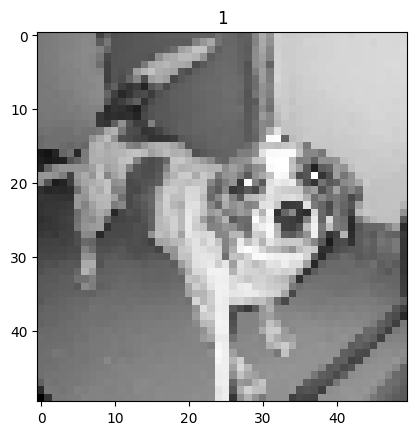

In [32]:
import matplotlib.pyplot as plt

i = 2
plt.imshow(training_data[i][0], cmap="gray")
plt.title(np.argmax(training_data[i][1]))
plt.show()

In [33]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 32, 5) #Input Channels, Output Channels, Kernel Size
        self.conv2 = nn.Conv2d(32, 64, 5) 
        self.conv3 = nn.Conv2d(64, 128, 5)

        self.pool1 = nn.MaxPool2d((2, 2))
        self.pool2 = nn.MaxPool2d((2, 2))
        self.pool3 = nn.MaxPool2d((2, 2))

        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        x = x.flatten(start_dim=1) # flattening out

        x =  F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)

        return x



net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [34]:
torch.cuda.is_available()

True

In [35]:
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

In [36]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("running on gpu")
else:
    device = torch.device("cpu")
    print("running on cpu")

running on gpu


In [37]:
net = Net().to(device)

In [39]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=1e-3)
loss_function = nn.MSELoss()

X = torch.tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0
y = torch.tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

BATCH_SIZE = 100 #if u have memory error then lower your batch size
EPOCHS = 10

def train(net):
    optimizer = optim.Adam(net.parameters(), lr=1e-3)
    loss_function = nn.MSELoss()
    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)): #StartPos=0, to trainX with stepSize=BATCH_SIZE
            # print(i, i+BATCH_SIZE)
            batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50).float().to(device) 
            batch_y = train_y[i:i+BATCH_SIZE].float().to(device) 

            net.zero_grad()
            # optimizaer.zero_grad()

            outputs = net(batch_X)
            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()

        print(f"Epoch: {epoch}. Loss: {loss}")



def test(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i]).to(device)
            net_out = net(test_X[i].view(-1, 1, 50, 50).to(device))[0]  # returns a list, 
            predicted_class = torch.argmax(net_out)

            if predicted_class == real_class:
                correct += 1
            total += 1
    print("Accuracy: ", round(correct/total, 3))


print("Training our Model")
train(net)
print("Testing our Model")
test(net)

300
2700
300
Training our Model


100%|██████████| 27/27 [00:00<00:00, 46.23it/s]


Epoch: 0. Loss: 0.20517593622207642


100%|██████████| 27/27 [00:00<00:00, 68.29it/s]


Epoch: 1. Loss: 0.19025374948978424


100%|██████████| 27/27 [00:00<00:00, 67.33it/s]


Epoch: 2. Loss: 0.184569850564003


100%|██████████| 27/27 [00:00<00:00, 67.83it/s]


Epoch: 3. Loss: 0.18044352531433105


100%|██████████| 27/27 [00:00<00:00, 67.43it/s]


Epoch: 4. Loss: 0.1730371117591858


100%|██████████| 27/27 [00:00<00:00, 67.12it/s]


Epoch: 5. Loss: 0.16476672887802124


100%|██████████| 27/27 [00:00<00:00, 67.00it/s]


Epoch: 6. Loss: 0.15258799493312836


100%|██████████| 27/27 [00:00<00:00, 66.18it/s]


Epoch: 7. Loss: 0.13773153722286224


100%|██████████| 27/27 [00:00<00:00, 68.01it/s]


Epoch: 8. Loss: 0.13609783351421356


100%|██████████| 27/27 [00:00<00:00, 67.67it/s]


Epoch: 9. Loss: 0.14862601459026337
Testing our Model


100%|██████████| 300/300 [00:00<00:00, 799.88it/s]

Accuracy:  0.643
